In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
from pathlib import Path
import tempfile

import numpy as np
from umap import UMAP

In [4]:
import roicat

In [5]:
# Import vrAnalysis related code
from vrAnalysis import database

In [6]:
# Create link to vrDatabase containing all data and get session paths for target mouse
mouseName = "ATL027"
planeName = "plane0"
vrdb = database.vrDatabase('vrSessions')
ises = vrdb.iterSessions(imaging=True, mouseName=mouseName, dontTrack=False)
pathList = []
for ses in ises:
    pathList.append(ses.sessionPath())
for idx, pl in enumerate(pathList): print(idx, pl)

0 C:\Users\andrew\Documents\localData\ATL027\2023-07-19\701
1 C:\Users\andrew\Documents\localData\ATL027\2023-07-20\701
2 C:\Users\andrew\Documents\localData\ATL027\2023-07-21\701
3 C:\Users\andrew\Documents\localData\ATL027\2023-07-24\701
4 C:\Users\andrew\Documents\localData\ATL027\2023-07-25\701
5 C:\Users\andrew\Documents\localData\ATL027\2023-07-26\701
6 C:\Users\andrew\Documents\localData\ATL027\2023-07-27\701
7 C:\Users\andrew\Documents\localData\ATL027\2023-07-28\701
8 C:\Users\andrew\Documents\localData\ATL027\2023-08-01\701
9 C:\Users\andrew\Documents\localData\ATL027\2023-08-02\701
10 C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702
11 C:\Users\andrew\Documents\localData\ATL027\2023-08-07\701
12 C:\Users\andrew\Documents\localData\ATL027\2023-08-08\701
13 C:\Users\andrew\Documents\localData\ATL027\2023-08-09\701


In [7]:
dir_allOuterFolders = pathList[10] #r'/media/rich/bigSSD/analysis_data/face_rhythm/mouse_0403L/stat_and_ops'

pathSuffixToStat = 'stat.npy'
pathSuffixToOps = 'ops.npy'

paths_allStat = roicat.helpers.find_paths(
    dir_outer=dir_allOuterFolders,
    reMatch=pathSuffixToStat,
    depth=6,
)[:]
paths_allOps  = np.array([Path(path).resolve().parent / pathSuffixToOps for path in paths_allStat])[:]

print(f'paths to all stat files:');
[print(path) for path in paths_allStat];
print('');
print(f'paths to all ops files:');
[print(path) for path in paths_allOps];

paths to all stat files:
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane0\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane1\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane2\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane3\stat.npy
C:\Users\andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane4\stat.npy

paths to all ops files:
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane0\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane1\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane2\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane3\ops.npy
C:\Users\Andrew\Documents\localData\ATL027\2023-08-04\702\suite2p\plane4\ops.npy


In [8]:
data = roicat.data_importing.Data_suite2p(
    paths_statFiles=paths_allStat,
    paths_opsFiles=paths_allOps,
    um_per_pixel=1.6,  
    new_or_old_suite2p='new',
    type_meanImg='meanImgE',
    verbose=True,
)

assert data.check_completeness(verbose=False)['classification_inference'], f"Data object is missing attributes necessary for tracking."

c:\users\andrew\documents\github\roicat\roicat\util.py:416: UserWarning: RH WARNING: unable to get gcc version. Got error: [WinError 2] The system cannot find the file specified
  warnings.warn(f'RH WARNING: unable to get gcc version. Got error: {e}')


Starting: Importing FOV images from ops files
Completed: Set FOV_height and FOV_width successfully.
Completed: Imported 5 FOV images.
Setting FOV_images...
Completed: Set FOV_images for 5 sessions successfully.
Importing spatial footprints from stat files.


100%|██████████| 5/5 [00:02<00:00,  2.00it/s]


Imported 5 sessions of spatial footprints into sparse arrays.
Completed: Set spatialFootprints for 5 sessions successfully.
Completed: Created session_bool.
Completed: Created centroids.
Starting: Creating centered ROI images from spatial footprints...
Completed: Created ROI images.


In [10]:
DEVICE = roicat.helpers.set_device(use_GPU=True, verbose=True)
dir_temp = tempfile.gettempdir()

roinet = roicat.ROInet.ROInet_embedder(
    device=DEVICE,  ## Which torch device to use ('cpu', 'cuda', etc.)
    dir_networkFiles=dir_temp,  ## Directory to download the pretrained network to
    download_method='check_local_first',  ## Check to see if a model has already been downloaded to the location (will skip if hash matches)
    download_url='https://osf.io/c8m3b/download',  ## URL of the model
    download_hash='357a8d9b630ec79f3e015d0056a4c2d5',  ## Hash of the model file
    forward_pass_version='head',  ## How the data is passed through the network
    verbose=True,  ## Whether to print updates
)

roinet.generate_dataloader(
    ROI_images=data.ROI_images,  ## Input images of ROIs
    um_per_pixel=data.um_per_pixel,  ## Resolution of FOV
    pref_plot=False,  ## Whether or not to plot the ROI sizes
);
images = roinet.ROI_images_rs

Using device: cuda:0
File already exists locally: C:\Users\Andrew\AppData\Local\Temp\ROInet.zip
Hash of local file matches provided hash_hex.
Extracting C:\Users\Andrew\AppData\Local\Temp\ROInet.zip to C:\Users\Andrew\AppData\Local\Temp.
Completed zip extraction.
Imported model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\model.py
Loaded params_model from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\params.json
Generated network using params_model
Loaded state_dict into network from C:\Users\Andrew\AppData\Local\Temp\ROInet_classification_20220902\ConvNext_tiny__1_0_unfrozen__simCLR.pth
Loaded network onto device cuda:0
Starting Image Resizer
Creating dataloader
Defined image transformations: Sequential(
  (0): ScaleDynamicRange(scaler_bounds=(0, 1))
  (1): Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
  (2): TileChannels(dim=0)
)
Defined dataset
Defined dataloader



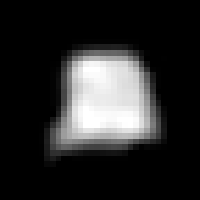

In [11]:
roicat.visualization.display_toggle_image_stack(images[:1000], image_size=(200,200))

In [12]:
roinet.generate_latents();

starting: running data through network


  0%|          | 0/2150 [00:01<?, ?it/s]

completed: running data through network


In [13]:
model_umap = UMAP(
    n_neighbors=25,
    n_components=2,
    n_epochs=400,
    verbose=True,
    densmap=False,
)
emb = model_umap.fit_transform(roinet.latents)

UMAP(n_epochs=400, n_neighbors=25, verbose=True)
Thu Dec 12 10:10:30 2024 Construct fuzzy simplicial set
Thu Dec 12 10:10:30 2024 Finding Nearest Neighbors
Thu Dec 12 10:10:30 2024 Building RP forest with 12 trees
Thu Dec 12 10:10:33 2024 NN descent for 14 iterations
	 1  /  14
	 2  /  14
	 3  /  14
	Stopping threshold met -- exiting after 3 iterations
Thu Dec 12 10:10:40 2024 Finished Nearest Neighbor Search
Thu Dec 12 10:10:42 2024 Construct embedding


Epochs completed:   0%|            0/400 [00:00]

	completed  0  /  400 epochs
	completed  40  /  400 epochs
	completed  80  /  400 epochs
	completed  120  /  400 epochs
	completed  160  /  400 epochs
	completed  200  /  400 epochs
	completed  240  /  400 epochs
	completed  280  /  400 epochs
	completed  320  /  400 epochs
	completed  360  /  400 epochs
Thu Dec 12 10:10:45 2024 Finished embedding


In [17]:
idx_images_overlay = roicat.visualization.get_spread_out_points(
    emb,
    n_ims=min(emb.shape[0], 1500),  ## Select number of overlayed images here
    dist_im_to_point=0.8,
#     border_frac=0.05,
)

images_overlay = images[idx_images_overlay]

In [18]:
images = np.concatenate(data.ROI_images, axis=0)

In [16]:
## Run the ImageLabeler class
with roicat.helpers.ImageLabeler(
    image_array=images, 
    start_index=0,  ## Change the starting image index here.
    random_order=True,  ## Randomize the order of images
    path_csv=None,  ## If None, then a temporary path will be used.
    resize_factor=10.0,  
    verbose=True,
    key_end='Escape',  ## Closes GUI
    key_prev='Left',  ## Goes to previous image
    key_next='Right',  ## Goes to next image
) as labeler:  ## Running this object within a context manager allows it to crash gracefully
    labeler.run()

Hello from update_selection


In [51]:
import holoviews as hv
import numpy as np
import os
import tempfile
import scipy.interpolate
import sklearn.neighbors

class ScatterSelector:
    """
    A class for creating interactive scatter plots with region selection and optional
    image overlays using holoviews/bokeh.
    
    Args:
        data (np.ndarray): 
            Input data for scatter plot with shape (n_samples, 2).
        images_overlay (np.ndarray, optional): 
            3D array (grayscale) or 4D array (RGB) of images to overlay.
        idx_images_overlay (np.ndarray, optional): 
            Indices mapping images to data points, shape (n_images,).
        size_images_overlay (float, optional): 
            Size of overlay images relative to axis units.
        frac_overlap_allowed (float): 
            Allowed fraction of image overlap if auto-sizing.
        image_overlay_raster_size (Tuple[int, int], optional): 
            Size of rasterized overlay in pixels.
        path (str, optional): 
            Path to save selected indices.
        figsize (Tuple[int, int]): 
            Figure size in pixels.
        alpha_points (float): 
            Scatter plot point transparency.
        size_points (float): 
            Scatter plot point size.
        color_points (Union[str, List[str]]): 
            Scatter plot point color.
    """
    
    def __init__(
        self,
        data: np.ndarray,
        images_overlay: np.ndarray = None,
        idx_images_overlay: np.ndarray = None,
        size_images_overlay: float = None,
        frac_overlap_allowed: float = 0.5,
        image_overlay_raster_size: tuple = None,
        path: str = None,
        figsize: tuple = (300, 300),
        alpha_points: float = 0.5,
        size_points: float = 1,
        color_points: str = 'k',
    ):
        self._validate_inputs(data, images_overlay, idx_images_overlay)
        
        self.data = data
        self.images_overlay = images_overlay
        self.idx_images_overlay = idx_images_overlay
        self.size_images_overlay = size_images_overlay
        self.frac_overlap_allowed = frac_overlap_allowed
        self.image_overlay_raster_size = image_overlay_raster_size or figsize
        self.figsize = figsize
        self.alpha_points = alpha_points
        self.size_points = size_points
        self.color_points = color_points
        
        self.path_tempfile = path or os.path.join(tempfile.gettempdir(), 'indices.csv')
        self.selection = None
        self.points = None
        self.layout = None
        self._selection_callbacks = []
        
        # Initialize holoviews extension
        hv.extension('bokeh')
        
    def _validate_inputs(self, data, images_overlay, idx_images_overlay):
        """Validate input parameters."""
        assert isinstance(data, np.ndarray), 'data must be a numpy array'
        assert data.ndim == 2, 'data must have 2 dimensions'
        assert data.shape[1] == 2, 'data must have 2 columns'
        
        if images_overlay is not None:
            assert isinstance(images_overlay, np.ndarray), 'images_overlay must be a numpy array'
            assert images_overlay.ndim in [3, 4], 'images_overlay must have 3 or 4 dimensions'
            assert images_overlay.shape[0] == idx_images_overlay.shape[0], \
                'images_overlay must have same number of images as idx_images_overlay'

    def add_selection_callback(self, callback):
        """Add a callback function to be called when selection changes."""
        self._selection_callbacks.append(callback)
        
    def _selection_callback(self, index):
        """Internal callback that handles selection changes."""
        # Save indices to file
        if os.path.exists(self.path_tempfile):
            os.remove(self.path_tempfile)
        with open(self.path_tempfile, 'w') as f:
            f.write(','.join(map(str, index)))
            
        # Call all registered callbacks
        for callback in self._selection_callbacks:
            callback(index)
            
        return self.points
    
    def get_selected_indices(self):
        """Get currently selected indices from temp file."""
        if os.path.exists(self.path_tempfile):
            with open(self.path_tempfile, 'r') as f:
                indices = f.read().split(',')
            return [int(i) for i in indices if i != ''] if indices else None
        return None
    
    def _create_image_overlay(self):
        """Create image overlay for scatter plot."""
        if self.images_overlay is None:
            return None
            
        min_emb = np.nanmin(self.data, axis=0)
        max_emb = np.nanmax(self.data, axis=0)
        range_emb = max_emb - min_emb
        aspect_ratio = range_emb[1] / range_emb[0]
        lims_canvas = ((min_emb - range_emb*0.05), (max_emb + range_emb*0.05))
        range_canvas = lims_canvas[1] - lims_canvas[0]
        
        # Auto-calculate image size if not provided
        if self.size_images_overlay is None:
            nn = sklearn.neighbors.NearestNeighbors(n_neighbors=2)
            nn.fit(self.data[self.idx_images_overlay])
            min_dist = nn.kneighbors_graph(
                self.data[self.idx_images_overlay], 
                n_neighbors=2,
                mode='distance'
            )
            min_dist.eliminate_zeros()
            min_dist = np.nanmin(min_dist.data)
            self.size_images_overlay = float(min_dist) * (1 + self.frac_overlap_allowed)
            
        if isinstance(self.size_images_overlay, (int, float)):
            self.size_images_overlay = np.array([
                self.size_images_overlay / aspect_ratio, 
                self.size_images_overlay
            ])
            
        # Create canvas for images
        canvas = np.zeros((*self.image_overlay_raster_size, 4))
        
        # Setup interpolation for mapping data coordinates to pixel coordinates
        interp_x = scipy.interpolate.interp1d(
            x=np.linspace(lims_canvas[0][0], lims_canvas[1][0], 
                         num=self.image_overlay_raster_size[0], endpoint=False),
            y=np.linspace(0, self.image_overlay_raster_size[0], 
                         num=self.image_overlay_raster_size[0], endpoint=False),
        )
        interp_y = scipy.interpolate.interp1d(
            x=np.linspace(lims_canvas[0][1], lims_canvas[1][1], 
                         num=self.image_overlay_raster_size[1], endpoint=False),
            y=np.linspace(0, self.image_overlay_raster_size[1], 
                         num=self.image_overlay_raster_size[1], endpoint=False),
        )
        
        # Place each image on canvas
        for image, idx in zip(self.images_overlay, self.idx_images_overlay):
            sz_x = int((self.size_images_overlay[0] / range_canvas[0]) * 
                      self.image_overlay_raster_size[0])
            sz_y = int((self.size_images_overlay[1] / range_canvas[1]) * 
                      self.image_overlay_raster_size[1])
            
            # Interpolate image to desired size
            im_interp = self._interpolate_image(image, sz_x, sz_y)
            
            # Convert to RGB if grayscale
            image_rgb = (np.stack([self._normalize_image(im_interp)] * 3, axis=-1) 
                        if im_interp.ndim == 2 else im_interp)
            
            # Calculate image placement coordinates
            x1 = int(interp_x(self.data[idx,0]) - sz_x / 2)
            y1 = int(interp_y(self.data[idx,1]) - sz_y / 2)
            x2 = x1 + sz_x
            y2 = y1 + sz_y
            
            # Place image on canvas
            if (x1 >= 0 and x2 <= self.image_overlay_raster_size[0] and 
                y1 >= 0 and y2 <= self.image_overlay_raster_size[1]):
                canvas[y1:y2, x1:x2, :3] = image_rgb
                canvas[y1:y2, x1:x2, 3] = 1
        
        canvas = np.flipud(canvas)
        return hv.RGB(canvas, bounds=(
            lims_canvas[0][0], lims_canvas[0][1], 
            lims_canvas[1][0], lims_canvas[1][1]
        ))
    
    @staticmethod
    def _normalize_image(image):
        """Normalize image to [0,1] range."""
        return (image - np.min(image)) / (np.max(image) - np.min(image))
    
    def _interpolate_image(self, image, sz_x, sz_y):
        """Interpolate image to desired size."""
        interpolator = scipy.interpolate.RegularGridInterpolator(
            points=(
                np.linspace(0, image.shape[0], num=image.shape[0], endpoint=False),
                np.linspace(0, image.shape[1], num=image.shape[1], endpoint=False),
            ),
            values=image,
            bounds_error=False,
            fill_value=0,
        )
        
        x = np.linspace(0, image.shape[0], num=sz_x, endpoint=False)
        y = np.linspace(0, image.shape[1], num=sz_y, endpoint=False)
        coords = np.stack(np.meshgrid(x, y), axis=-1)
        
        return interpolator(coords)
    
    def create_plot(self):
        """Create and return the interactive scatter plot."""
        # Create scatter plot
        self.points = hv.Points(self.data)
        self.points.opts(
            alpha=self.alpha_points,
            size=self.size_points,
            color=self.color_points,
        )
        
        # Set up selection stream
        self.selection = hv.streams.Selection1D(source=self.points)
        self.selection.param.watch_values(self._selection_callback, 'index')
        
        # Create layout
        self.layout = self.points.opts(
            tools=['lasso_select', 'box_select'],
            width=self.figsize[0],
            height=self.figsize[1],
        )
        
        # Add image overlay if provided
        if self.images_overlay is not None:
            overlay = self._create_image_overlay()
            if overlay is not None:
                self.layout *= overlay
        
        # Set active tools
        self.layout = self.layout.opts(
            active_tools=['lasso_select', 'wheel_zoom']
        )
        
        return self.layout

    def display(self):
        """Create and display the interactive plot."""
        if self.layout is None:
            self.create_plot()
        try:
            from IPython.display import display
            display(self.layout)
        except ImportError:
            print('Warning: Could not import IPython.display. Cannot display plot.')

<img src='data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAEAAAABACAYAAACqaXHeAAAABHNCSVQICAgIfAhkiAAAAAlwSFlz
AAAB+wAAAfsBxc2miwAAABl0RVh0U29mdHdhcmUAd3d3Lmlua3NjYXBlLm9yZ5vuPBoAAA6zSURB
VHic7ZtpeFRVmsf/5966taWqUlUJ2UioBBJiIBAwCZtog9IOgjqACsogKtqirT2ttt069nQ/zDzt
tI4+CrJIREFaFgWhBXpUNhHZQoKBkIUASchWla1S+3ar7r1nPkDaCAnZKoQP/D7mnPOe9/xy76n3
nFSAW9ziFoPFNED2LLK5wcyBDObkb8ZkxuaoSYlI6ZcOKq1eWFdedqNzGHQBk9RMEwFAASkk0Xw3
ETacDNi2vtvc7L0ROdw0AjoSotQVkKSvHQz/wRO1lScGModBFbDMaNRN1A4tUBCS3lk7BWhQkgpD
lG4852/+7DWr1R3uHAZVQDsbh6ZPN7CyxUrCzJMRouusj0ipRwD2uKm0Zn5d2dFwzX1TCGhnmdGo
G62Nna+isiUqhkzuKrkQaJlPEv5mFl2fvGg2t/VnzkEV8F5ioioOEWkLG86fvbpthynjdhXYZziQ
x1hC9J2NFyi8vCTt91Fh04KGip0AaG9zuCk2wQCVyoNU3Hjezee9bq92duzzTmxsRJoy+jEZZZYo
GTKJ6SJngdJqAfRzpze0+jHreUtPc7gpBLQnIYK6BYp/uGhw9YK688eu7v95ysgshcg9qSLMo3JC
4jqLKQFBgdKDPoQ+Pltb8dUyQLpeDjeVgI6EgLIQFT5tEl3rn2losHVsexbZ3EyT9wE1uGdkIPcy
BGxn8QUq1QrA5nqW5i2tLqvrrM9NK6AdkVIvL9E9bZL/oyfMVd/jqvc8LylzRBKDJSzIExwhQzuL
QYGQj4rHfFTc8mUdu3E7yoLtbTe9gI4EqVgVkug2i5+uXGo919ixbRog+3fTbQ8qJe4ZOYNfMoTI
OoshUNosgO60AisX15aeI2PSIp5KiFLI9ubb1vV3Qb2ltwLakUCDAkWX7/nHKRmmGIl9VgYsUhJm
2NXjKYADtM1ygne9QQDIXlk49FBstMKx66D1v4+XuQr7vqTe0VcBHQlRWiOCbmmSYe2SqtL6q5rJ
zsTb7lKx3FKOYC4DoqyS/B5bvLPxvD9Qtf6saxYLQGJErmDOdOMr/zo96km1nElr8bmPOBwI9COv
HnFPRIwmkSOv9kcAS4heRsidOkpeWBgZM+UBrTFAXNYL5Vf2ii9c1trNzpYdaoVil3WIc+wdk+gQ
noie3ecCcxt9ITcLAPWt/laGEO/9U6PmzZkenTtsSMQ8uYywJVW+grCstAvCIaAdArAsIWkRDDs/
KzLm2YcjY1Lv0UdW73HabE9n6V66cxSzfEmuJssTpKGVp+0vHq73FwL46eOjpMpbRAnNmJFrGJNu
Ukf9Yrz+3rghiumCKNXXWPhLYcjxGsIpoCMsIRoFITkW8AuyM8jC1+/QLx4bozCEJIq38+1rtpR6
V/yzb8eBlRb3fo5l783N0CWolAzJHaVNzkrTzlEp2bQ2q3TC5gn6wpnoQAmwSiGh2GitnTmVMc5O
UyfKWUKCIsU7+fZDKwqdT6DDpvkzAX4/+AMFjk0tDp5GRXLpQ2MUmhgDp5gxQT8+Y7hyPsMi8uxF
71H0oebujHALECjFKaW9Lm68n18wXp2kVzIcABytD5iXFzg+WVXkegpAsOOYziqo0OkK76GyquC3
ltZAzMhhqlSNmmWTE5T6e3IN05ITFLM4GdN0vtZ3ob8Jh1NAKXFbm5PtLU/eqTSlGjkNAJjdgn/N
aedXa0tdi7+t9G0FIF49rtMSEgAs1kDLkTPO7ebm4IUWeyh1bKomXqlgMG6kJmHcSM0clYLJ8XtR
1GTnbV3F6I5wCGikAb402npp1h1s7LQUZZSMIfALFOuL3UUrfnS8+rez7v9qcold5tilgHbO1fjK
9ubb17u9oshxzMiUBKXWqJNxd+fqb0tLVs4lILFnK71H0Ind7uiPgACVcFJlrb0tV6DzxqqTIhUM
CwDf1/rrVhTa33/3pGPxJYdQ2l2cbgVcQSosdx8uqnDtbGjh9SlDVSMNWhlnilfqZk42Th2ZpLpf
xrHec5e815zrr0dfBZSwzkZfqsv+1FS1KUknUwPARVvItfKUY+cn57yP7qv07UE3p8B2uhUwLk09
e0SCOrK+hbdYHYLjRIl71wWzv9jpEoeOHhGRrJAzyEyNiJuUqX0g2sBN5kGK6y2Blp5M3lsB9Qh4
y2Ja6x6+i0ucmKgwMATwhSjdUu49tKrQ/pvN5d53ml2CGwCmJipmKjgmyuaXzNeL2a0AkQ01Th5j
2DktO3Jyk8f9vcOBQHV94OK+fPumJmvQHxJoWkaKWq9Vs+yUsbq0zGT1I4RgeH2b5wef7+c7bl8F
eKgoHVVZa8ZPEORzR6sT1BzDUAD/d9F78e2Tzv99v8D+fLVTqAKAsbGamKey1Mt9Ann4eH3gTXTz
idWtAJ8PQWOk7NzSeQn/OTHDuEikVF1R4z8BQCy+6D1aWRfY0tTGG2OM8rRoPaeIj5ZHzJxszElN
VM8K8JS5WOfv8mzRnQAKoEhmt8gyPM4lU9SmBK1MCQBnW4KONT86v1hZ1PbwSXPw4JWussVjtH9Y
NCoiL9UoH/6PSu8jFrfY2t36erQHXLIEakMi1SydmzB31h3GGXFDFNPaK8Rme9B79Ixrd0WN+1ij
NRQ/doRmuFLBkHSTOm5GruG+pFjFdAmorG4IXH1Qua6ASniclfFtDYt+oUjKipPrCQB7QBQ2lrgP
fFzm+9XWUtcqJ3/5vDLDpJ79XHZk3u8nGZ42qlj1+ydtbxysCezrydp6ugmipNJ7WBPB5tydY0jP
HaVNzs3QzeE4ZpTbI+ZbnSFPbVOw9vsfnVvqWnirPyCNGD08IlqtYkh2hjZ5dErEQzoNm+6ykyOt
Lt5/PQEuSRRKo22VkydK+vvS1XEKlhCJAnsqvcVvH7f/ZU2R67eXbMEGAMiIV5oWZWiWvz5Fv2xG
sjqNJQRvn3Rs2lji/lNP19VjAQDgD7FHhujZB9OGqYxRkZxixgRDVlqS6uEOFaJUVu0rPFzctrnF
JqijImVp8dEKVWyUXDk92zAuMZ6bFwpBU1HrOw6AdhQgUooChb0+ItMbWJitSo5Ws3IAOGEOtL53
0vHZih9sC4vtofZ7Qu6523V/fmGcds1TY3V36pUsBwAbSlxnVh2xLfAD/IAIMDf7XYIkNmXfpp2l
18rkAJAy9HKFaIr/qULkeQQKy9zf1JgDB2uaeFNGijo5QsUyacNUUTOnGO42xSnv4oOwpDi1zYkc
efUc3I5Gk6PhyTuVKaOGyLUAYPGIoY9Pu/atL/L92+4q9wbflRJ2Trpm/jPjdBtfnqB/dIThcl8A
KG7hbRuKnb8qsQsVvVlTrwQAQMUlf3kwJI24Z4JhPMtcfng5GcH49GsrxJpGvvHIaeem2ma+KSjQ
lIwUdYyCY8j4dE1KzijNnIP2llF2wcXNnsoapw9XxsgYAl6k+KzUXbi2yP3KR2ecf6z3BFsBICdW
nvnIaG3eHybqX7vbpEqUMT+9OL4Qpe8VON7dXuFd39v19FoAABRVePbGGuXTszO0P7tu6lghUonE
llRdrhArLvmKdh9u29jcFiRRkfLUxBiFNiqSU9icoZQHo5mYBI1MBgBH6wMNb+U7Pnw337H4gi1Y
ciWs+uks3Z9fztUvfzxTm9Ne8XXkvQLHNytOOZeiD4e0PgkAIAYCYknKUNUDSXEKzdWNpnil7r4p
xqkjTarZMtk/K8TQ6Qve78qqvXurGwIJqcOUKfUWHsm8KGvxSP68YudXq4pcj39X49uOK2X142O0
Tz5/u/7TVybqH0rSya6ZBwD21/gubbrgWdDgEOx9W
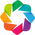

BokehModel(combine_events=True, render_bundle={'docs_json': {'2408dfc6-4ff8-4e6c-b8aa-f53781e0d2f1': {'version…

In [52]:
# Basic usage
selector = ScatterSelector(
    emb,
    # images_overlay=images_overlay[:, 6:30][:,:,6:30],
    # idx_images_overlay=idx_images_overlay,
    size_images_overlay=0.25,
    frac_overlap_allowed=0.25,
    figsize=(800, 800),
    alpha_points=1.0,
    size_points=3.0,
    color_points='b',
)

selector.display()

# With callback
def on_selection(indices):
    print(f"Selected points: {indices}")
    
selector.add_selection_callback(on_selection)

# # With image overlay
# selector = ScatterSelector(
#     emb,
#     images_overlay=images_overlay[:, 6:30][:,:,6:30],
#     idx_images_overlay=idx_images_overlay,
#     size_images_overlay=0.25,
#     frac_overlap_allowed=0.25,
#     figsize=(800, 800),
#     alpha_points=1.0,
#     size_points=3.0,
#     color_points='b',
# )
# selector.display()

In [70]:
import numpy as np
from bokeh.layouts import gridplot
from bokeh.plotting import figure, show
from bokeh.models import TapTool, CustomJS, ColumnDataSource

class ImageViewer:
    def __init__(self, images, width=400, height=400):
        """
        Initialize the ImageViewer with specified dimensions for each panel.
        
        Args:
            width (int): Width of each panel in pixels
            height (int): Height of each panel in pixels
        """
        self.images = images
        self.width = width
        self.height = height
        self.create_panels()
        
    def create_panels(self):
        """
        Create two panels with the provided images.
        """
        self.select_images()
        img1, img2 = self.images[self.idx]

        # Create ColumnDataSources for both images
        self.source1 = ColumnDataSource(data=dict(image=[img1]))
        self.source2 = ColumnDataSource(data=dict(image=[img2]))
        
        # Create the first figure
        p1 = figure(width=self.width, height=self.height, title="Image 1", tools="tap")
        p1.image(image='image', x=0, y=0, dw=img1.shape[1], dh=img1.shape[0], 
                palette="Viridis256", source=self.source1)
        
        # Create the second figure
        p2 = figure(width=self.width, height=self.height, title="Image 2", tools="tap")
        p2.image(image='image', x=0, y=0, dw=img2.shape[1], dh=img2.shape[0], 
                palette="Viridis256", source=self.source2)
        
        # Create a list of all images as a ColumnDataSource
        all_images = ColumnDataSource(data=dict(
            images=list(self.images)
        ))
        
        # Create JavaScript callback
        callback = CustomJS(args=dict(source1=self.source1, 
                                    source2=self.source2,
                                    all_images=all_images), 
                          code="""
            // Get total number of images
            const n_images = all_images.data.images.length;
            
            // Select two random indices
            const idx1 = Math.floor(Math.random() * n_images);
            let idx2 = Math.floor(Math.random() * (n_images - 1));
            if (idx2 >= idx1) idx2 += 1;  // Ensure we don't pick the same image twice
            
            // Update the image sources
            source1.data.image = [all_images.data.images[idx1]];
            source2.data.image = [all_images.data.images[idx2]];
            
            // Trigger update of the data sources
            source1.change.emit();
            source2.change.emit();
        """)
        
        # Add tap callbacks to both figures
        p1.js_on_event('tap', callback)
        p2.js_on_event('tap', callback)
        
        self.figures = [p1, p2]
    
    def select_images(self):
        """Pick which images to show."""
        self.idx = np.random.permutation(len(self.images))[:2]
    
    def show(self):
        """Display the grid of figures."""
        grid = gridplot([self.figures], toolbar_location="right")
        show(grid)

# Example usage
images = np.random.randn(10, 100, 100)
viewer = ImageViewer(images, width=400, height=400)
viewer.show()

In [76]:
import numpy as np
from bokeh.layouts import gridplot, column
from bokeh.plotting import figure, show
from bokeh.models import TapTool, CustomJS, ColumnDataSource, TextInput, Div

class ImageViewer:
    def __init__(self, images, width=400, height=400):
        """
        Initialize the ImageViewer with specified dimensions for each panel.
        """
        self.images = images
        self.width = width
        self.height = height
        self.labels = {}  # Dictionary to store image labels
        self.create_panels()
        
    def create_panels(self):
        """
        Create three panels: two for images and one for text interaction.
        """
        self.select_images()
        img1, img2 = self.images[self.idx]

        # Create ColumnDataSources for images
        self.source1 = ColumnDataSource(data=dict(image=[img1]))
        self.source2 = ColumnDataSource(data=dict(image=[img2]))
        
        # Store current indices and labels dictionary as a ColumnDataSource
        self.label_source = ColumnDataSource(data=dict(
            current_indices=[self.idx[0], self.idx[1]],
            label_indices=list(self.labels.keys()),
            label_values=list(self.labels.values())
        ))
        
        # Create image panels
        p1 = figure(width=self.width, height=self.height, title="Image 1", tools="tap")
        p1.image(image='image', x=0, y=0, dw=img1.shape[1], dh=img1.shape[0], 
                palette="Viridis256", source=self.source1)
        
        p2 = figure(width=self.width, height=self.height, title="Image 2", tools="tap")
        p2.image(image='image', x=0, y=0, dw=img2.shape[1], dh=img2.shape[0], 
                palette="Viridis256", source=self.source2)
        
        # Create text input and list panel
        text_input = TextInput(value="", placeholder="Type and press Enter to label current images...")
        
        list_div = Div(text="", width=self.width, height=350,
                      styles={'overflow-y': 'auto',
                             'border': '1px solid #ddd',
                             'padding': '10px',
                             'background-color': '#f5f5f5',
                             'margin-top': '10px'})

        # Create JavaScript callback for text input
        text_callback = CustomJS(args=dict(
            list_div=list_div, 
            label_source=self.label_source,
            p1=p1,
            p2=p2), code="""
            if (cb_obj.value.trim() !== '') {
                const label = cb_obj.value.trim();
                const currentIndices = label_source.data.current_indices;
                let labelIndices = label_source.data.label_indices;
                let labelValues = label_source.data.label_values;
                
                // Update labels for both current images
                currentIndices.forEach(idx => {
                    const existingIndex = labelIndices.indexOf(idx);
                    if (existingIndex === -1) {
                        labelIndices.push(idx);
                        labelValues.push(label);
                    } else {
                        labelValues[existingIndex] = label;
                    }
                });
                
                // Update the label source
                label_source.data.label_indices = labelIndices;
                label_source.data.label_values = labelValues;
                
                // Get unique labels and their counts
                const labelCounts = {};
                labelValues.forEach(value => {
                    labelCounts[value] = (labelCounts[value] || 0) + 1;
                });
                
                // Create HTML for unique labels
                const itemsHtml = Object.entries(labelCounts).map(([label, count]) => `
                    <div class="list-item" style="
                        padding: 8px;
                        margin: 4px;
                        background: white;
                        border-radius: 4px;
                        cursor: pointer;
                        transition: background-color 0.2s;
                        box-shadow: 0 1px 2px rgba(0,0,0,0.1);
                        flex: 0 1 auto;
                    "
                    onmouseover="this.style.backgroundColor='#f0f0f0'"
                    onmouseout="this.style.backgroundColor='white'"
                    onclick="console.log('Clicked:', '${label}')"
                    >${label} (${count})</div>
                `).join('');
                
                // Update the div content
                list_div.text = `
                    <div style="
                        display: flex;
                        flex-wrap: wrap;
                        gap: 8px;
                        align-items: flex-start;
                    ">
                        ${itemsHtml}
                    </div>
                `;
                
                // Update titles
                p1.title.text = `Image 1 - Label: ${label}`;
                p2.title.text = `Image 2 - Label: ${label}`;
                
                // Clear input
                cb_obj.value = '';
                
                label_source.change.emit();
            }
        """)
        
        # Create image update callback
        image_callback = CustomJS(args=dict(
            source1=self.source1, 
            source2=self.source2,
            label_source=self.label_source,
            p1=p1,
            p2=p2,
            all_images=ColumnDataSource(data=dict(images=list(self.images)))), 
            code="""
            const n_images = all_images.data.images.length;
            const idx1 = Math.floor(Math.random() * n_images);
            let idx2 = Math.floor(Math.random() * (n_images - 1));
            if (idx2 >= idx1) idx2 += 1;
            
            // Update images
            source1.data.image = [all_images.data.images[idx1]];
            source2.data.image = [all_images.data.images[idx2]];
            
            // Update current indices
            label_source.data.current_indices = [idx1, idx2];
            
            // Find existing labels
            const labelIndices = label_source.data.label_indices;
            const labelValues = label_source.data.label_values;
            const idx1LabelIndex = labelIndices.indexOf(idx1);
            const idx2LabelIndex = labelIndices.indexOf(idx2);
            
            // Update titles
            p1.title.text = `Image 1${idx1LabelIndex !== -1 ? ` - Label: ${labelValues[idx1LabelIndex]}` : ''}`;
            p2.title.text = `Image 2${idx2LabelIndex !== -1 ? ` - Label: ${labelValues[idx2LabelIndex]}` : ''}`;
            
            source1.change.emit();
            source2.change.emit();
            label_source.change.emit();
        """)
        
        # Add callbacks
        text_input.js_on_change('value', text_callback)
        p1.js_on_event('tap', image_callback)
        p2.js_on_event('tap', image_callback)
        
        # Create the text panel
        text_panel = column(text_input, list_div, width=self.width, height=self.height)
        
        self.figures = [p1, p2, text_panel]
    
    def select_images(self):
        """Pick which images to show."""
        self.idx = np.random.permutation(len(self.images))[:2]
    
    def show(self):
        """Display the grid of figures."""
        grid = gridplot([self.figures], toolbar_location="right")
        show(grid)

# Example usage
images = np.random.randn(10, 100, 100)
viewer = ImageViewer(images, width=400, height=400)
viewer.show()